## Sandbox Modesto

### Tablas y Figuras

In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import logging
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_blobs

from fkdc.config import _get_run_seeds, clasificadores, grillas, main_seed
from fkdc.datasets import Dataset
from fkdc.tarea import Tarea
from fkdc.utils import load_infos, refit_parsimoniously
from fkdc.utils import parse_basic_info

# Los experimentos del 29.10.2024 corrieron con main_seed = 2024
# Los experimentos del 19.05.2025 corrieron con main_seed = 2206
# Los experimentos del 23.05.2025 corrieron con main_seed = 2411
# Los experimentos del 07.06.2025 corrieron con main_seed = 1312
# Los experimentos del 12.06.2025 corrieron con main_seed = 1312 (igual a 07.06.2025)
run_seeds = _get_run_seeds()

# root_dir = Path("/Users/gonzalo/Git/fkdc/sandbox/v5")
root_dir = Path("/Users/gonzalo/Git/fkdc/")
data_dir = root_dir / "data"
# img_dir = root_dir / "img"
img_dir = root_dir / "docs/img"
run_dir = root_dir / "infos"
datasets_dir = root_dir / "datasets"
for directory in [data_dir, img_dir, run_dir, datasets_dir]:
    directory.mkdir(exist_ok=True)

In [3]:
logging.basicConfig(
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    level=logging.INFO,
    handlers=[logging.StreamHandler()],
)
logger = logging.getLogger(__name__)

In [4]:
info_pickle = data_dir / "basic_info.pkl"
force = False
if info_pickle.exists() and not force:
    bi = basic_info = pd.read_pickle(info_pickle)
else:
    infos = load_infos(run_dir)
    bi = basic_info = parse_basic_info(infos, main_seed)
    basic_info.to_pickle(info_pickle)

In [5]:
from sklearn.datasets import make_circles

In [40]:
ds = Dataset.de_fabrica(make_circles, n_samples=800, noise=0.05)

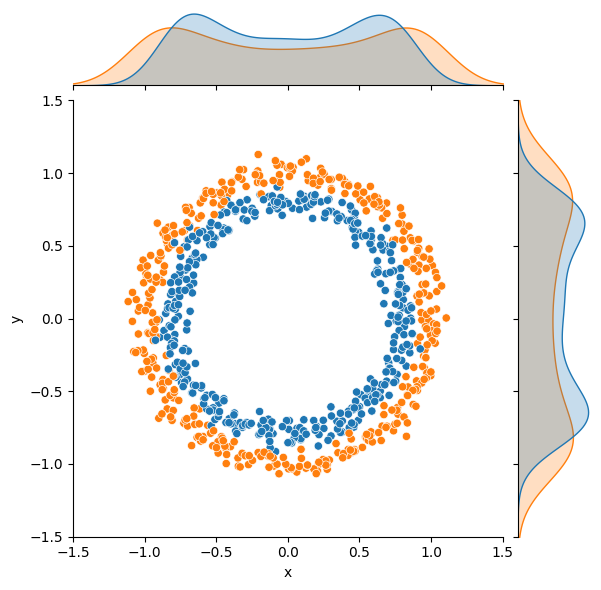

In [42]:
sns.jointplot(data=data, x="x", y="y", hue="group", legend=False)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.savefig(img_dir / "dos-circulos-jointplot.png")

In [ ]:
import seaborn as sns

sns.jointplot()

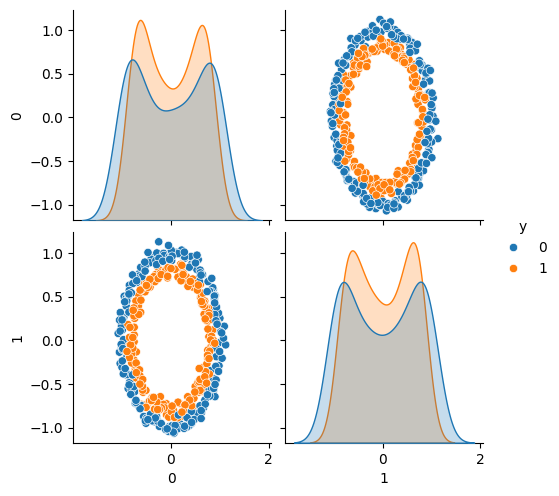

In [18]:
ds.pairplot()

In [ ]:
seed = main_seed
blobs = Dataset.de_fabrica(
    make_blobs,
    n_samples=(400, 400),
    n_features=2,
    centers=((0, 0), (10, 0)),
    random_state=seed,
)
blobs.scatter()
run_2blobs = data_dir / f"2blobs-{seed}-info.pkl"
force = False
if run_2blobs.exists() and not force:
    info = pickle.load(open(run_2blobs, "rb"))
else:
    tareas = {}
    for predicts_proba in [True, False]:
        tarea = tareas[predicts_proba] = Tarea(
            blobs,
            {
                nombre: (clf, grillas[nombre])
                for nombre, clf in clasificadores.items()
                if hasattr(clf, "predict_proba") is predicts_proba
            },
            scoring="neg_log_loss" if predicts_proba else "accuracy",
            seed=seed,
        )
        tarea.entrenar()
        tarea.evaluar()
    info = {**tareas[True].info, **tareas[False].info}
    pickle.dump(info, open(run_2blobs, "wb"))

sanity_check = (
    pd.DataFrame(info).T[["r2", "accuracy"]].astype(float).drop(index="base")
)
assert sanity_check.accuracy.eq(1).all() and sanity_check.r2.dropna().gt(0.999).all()

In [ ]:
import pickle

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
seed = run_seeds[0]
datasets_2d = ["lunas_lo", "espirales_lo", "circulos_lo"]
for nombre, ax in zip(datasets_2d, axs):
    ds = pickle.load(open(datasets_dir / f"{nombre}-{seed}.pkl", "rb"))
    ds.scatter(ax=ax)
    ax.set_title(nombre)
plt.tight_layout()
fig.savefig(img_dir / "datasets-lunas-circulos-espirales.svg")
# IMG 2: datasets 2d, low noise

### 2D, low noise

In [ ]:
datasets = [ds for ds in bi.dataset.unique() if ds.endswith("_lo")]

In [ ]:
colors = dict(zip(bi.clf.unique(), sns.color_palette("Set3")))
# exclude_clfs = ["base", "gnb", "lr", "]
# exclude_clfs = []
exclude_clfs = ["base"]

In [ ]:
delta_max_mean_dataset_acc = (
    bi.groupby(["dataset", "clf"])
    .accuracy.mean()
    .unstack("clf")
    .apply(lambda s: s - s.max(), axis=1)
)
mean_r2 = bi.groupby(["dataset", "clf"]).r2.mean().unstack("clf")

In [ ]:
mean_r2.loc[datasets]

In [ ]:
max_mean_acuracies = (
    bi.groupby(["dataset", "clf"])
    .accuracy.mean()
    .unstack("clf")
    .max(axis=1)
    .mul(100)
    .round(2)
    .sort_values()
)
from IPython.display import display, Markdown

df = (
    pd.concat([mean_r2, delta_max_mean_dataset_acc], keys=["r2", "delta_acc"])
    .T.reorder_levels([1, 0], axis=1)
    .sort_index(axis=1)
    .mul(100)
    .round(2)
)
for ds, acc in max_mean_acuracies.items():
    if not ds.endswith("digitos"):
        continue
    display(Markdown(f"#### {ds} (acc: {acc}%)"))
    display(df[ds].sort_values("r2", ascending=False))

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for idx, dataset in enumerate(datasets):
    ax = axs[idx]
    data = bi[bi.dataset.eq(dataset) & ~bi.clf.isin(exclude_clfs)].sort_values("clf")
    sns.boxplot(data, hue="clf", y="accuracy", gap=0.2, ax=ax, palette=colors)
    ax.set_title(dataset)
    ax.axhline(
        data.groupby("clf").accuracy.median().max(), linestyle="dotted", color="gray"
    )
    # ybot = np.percentile(data.accuracy.dropna(), 35)
    # ax.set_ylim(ybot, None)
    if idx != 0:
        ax.get_legend().set_visible(False)
fig.tight_layout()
fig.savefig(img_dir / "boxplot-lunas-espirales-circulos-new.svg")
# IMG 2: Detalle accuracy boxplot

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for idx, dataset in enumerate(datasets):
    ax = axs[idx]
    data = bi[bi.dataset.eq(dataset) & ~bi.clf.isin(exclude_clfs)].sort_values("clf")
    sns.boxplot(data, hue="clf", y="r2", gap=0.2, ax=ax, palette=colors)
    ax.set_title(dataset)
    ax.axhline(data.groupby("clf").r2.median().max(), linestyle="dotted", color="gray")
    # ybot = np.percentile(data.r2.dropna(), 35)
    # ax.set_ylim(ybot, None)
    if idx != 0:
        ax.get_legend().set_visible(False)
fig.tight_layout()
fig.savefig(img_dir / "boxplot-lunas-espirales-circulos-new.svg")
# IMG 2: Detalle r2 boxplot

In [ ]:
# IDEA: gbt con mayot max_depth; empata top perfs?

In [ ]:
clave_fkdc = ("espirales_lo", str(1434), "fkdc", str(main_seed), "neg_log_loss")
clave_kdc = ("espirales_lo", str(1434), "kdc", str(main_seed), "neg_log_loss")

In [ ]:
infos[clave_fkdc].fkdc.busqueda.best_params_

In [ ]:
infos[clave_kdc].kdc.busqueda.best_params_

In [ ]:
(infos[clave_fkdc].fkdc.r2, infos[clave_kdc].kdc.r2)

In [ ]:
busqueda = pd.DataFrame(infos[clave_fkdc]["fkdc"].busqueda.cv_results_)
data = busqueda.set_index(["param_alpha", "param_bandwidth"]).mean_test_score.unstack()
X = data.columns.values
Y = data.index.values
Z = data.values

fig, ax = plt.subplots(layout="constrained")
zmin, zmax = Z.min(), Z.max()
CS = ax.contourf(X, Y, Z, 15, cmap="viridis")
# CS = ax.contour(X, Y, Z, 15, cmap="viridis")
ax.set_title("Score para $\\alpha$ y $h$")
ax.set_xlabel("$h$")
ax.set_ylabel("$\\alpha$")
ax.scatter(X[Z.argmax(axis=1)], Y, marker="x", color="red")
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel("Score")
ax.set_xscale("log")
ax.set_xlim(10 ^ -3, 10 ^ 1)
# plt.tight_layout()
fig.savefig(img_dir / "heatmap-fkdc-2d-lo-new.svg")

In [ ]:
pd.DataFrame(
    {
        k[1:3]: info[k[2]].busqueda.best_estimator_.get_params()
        for k, info in infos.items()
        if k[0] == "helices_0" and k[2].endswith("kdc")
    }
).T.drop(columns="metric").unstack().reorder_levels([1, 0], axis=1).sort_index(
    axis=1
).drop(
    columns=("kdc", "alpha")
).value_counts().reset_index().round(
    4
)

In [ ]:
bi[bi.dataset.eq("helices_0") & bi.clf.str.endswith("kn")].set_index(
    ["semilla", "clf"]
).r2.unstack().plot(kind="scatter", y="fkn", x="kn")
# .assign(delta=lambda df: df.fkn.sub(df.kn)).mul(100).round(2)
plt.axline((0.5, 0.5), slope=1, color="gray", linestyle="dotted")
plt.title("$R^2$ por semilla para FKN y KN en `helices_0`")

In [ ]:
clave_fkn = ("eslabones_0", str(1434), "fkn", str(main_seed), "neg_log_loss")
clave_kn = ("eslabones_0", str(1434), "kn", str(main_seed), "neg_log_loss")

In [ ]:
infos[clave_fkn].fkn.busqueda.best_params_

In [ ]:
infos[clave_kn].kn.busqueda.best_params_

In [ ]:
kn_scores = (
    pd.DataFrame(infos[clave_kn].kn.busqueda.cv_results_)
    .loc[lambda df: df.param_weights.eq("distance")]
    .set_index("param_n_neighbors")
    .mean_test_score.sort_index()
)

In [ ]:
fkn_scores = (
    pd.DataFrame(infos[clave_fkn].fkn.busqueda.cv_results_)
    .loc[lambda df: df.param_weights.eq("distance")]
    .sort_values("mean_test_score", ascending=False)[
        ["param_alpha", "param_n_neighbors", "mean_test_score"]
    ]
    .groupby("param_n_neighbors")
    .first()
)

In [ ]:
both_scores = pd.concat([fkn_scores, kn_scores], keys=["fkn", "kn"], axis=1)
both_scores.loc[[1, 3, 12, 41, 144]].round(3)

In [ ]:
(
    bi[bi.dataset.eq("helices_0") & bi.clf.str.endswith("kn")]
    .set_index(["semilla", "clf"])
    .r2.unstack("clf")
    .plot(x="kn", y="fkn", kind="scatter")
)

In [ ]:
bi[bi.dataset.eq("eslabones_0") & bi.clf.str.endswith("kn")].set_index(
    ["semilla", "clf"]
).r2.unstack().plot(kind="scatter", y="fkn", x="kn")
# .assign(delta=lambda df: df.fkn.sub(df.kn)).mul(100).round(2)
plt.axline((0.5, 0.5), slope=1, color="gray", linestyle="dotted")
plt.title("$R^2$ por semilla para FKN y KN en `eslabones_0`")

In [ ]:
both_scores.drop(columns=("fkn", "param_alpha")).plot(figsize=(12, 6))
plt.xscale("log")
plt.xlabel("n_neighbors")
plt.ylabel("mean_test_score")

In [ ]:
pd.DataFrame(
    {
        k[1:3]: info[k[2]].busqueda.best_estimator_.get_params()
        for k, info in infos.items()
        if k[0] == "helices_0" and k[2].endswith("kn")
    }
).T[["alpha", "n_neighbors"]].unstack().reorder_levels([1, 0], axis=1).sort_index(
    axis=1
).drop(
    columns=("kn", "alpha")
)  # .value_counts().reset_index().round(4)

In [ ]:
pd.DataFrame(
    {
        k[1:3]: info[k[2]].busqueda.best_estimator_.get_params()
        for k, info in infos.items()
        if k[0] == "helices_0" and k[2].endswith("kn")
    }
)

In [ ]:
# probably throw this away?
sns.lineplot(busqueda, y="mean_test_score", x="param_bandwidth", hue="param_alpha")
plt.xscale("log")

In [ ]:
from itertools import product

some_seeds = np.random.choice(run_seeds, 3)
# some_seeds = [5167, 7446, 9083]  # well behaved
# some_seeds = [1134, 7815, 9616]  # weird
# some_seeds = [1134, 7815, 9083]  # mix
some_seeds = np.random.choice(run_seeds, 3)
fig, axs = plt.subplots(3, 3, figsize=(35, 30), layout="constrained")
for (ds, seed), ax in zip(product(datasets_2d, some_seeds), axs.flatten()):
    key = (ds + "_lo", str(seed), "fkdc", str(main_seed), "neg_log_loss")
    df = pd.DataFrame(infos[key]["fkdc"].busqueda.cv_results_)
    data = df.pivot(
        index="param_alpha", columns="param_bandwidth", values="mean_test_score"
    )
    X = data.columns.values
    Y = data.index.values
    Z = data.values
    zmin, zmax = Z.min(), Z.max()
    CS = ax.contourf(X, Y, Z, 25, cmap="viridis")
    ax.set_title(f"Exactitud para {key}")
    ax.set_xlabel("$h$")
    ax.set_ylabel("$\\alpha$")
    ax.scatter(X[Z.argmax(axis=1)], Y, marker="x", color="red")
    # Make a colorbar for the ContourSet returned by the contourf call.
    cbar = fig.colorbar(CS)
    # cbar.ax.set_ylabel("Exactitud")
    ax.set_xscale("log")
    # plt.tight_layout()
fig.savefig(img_dir / "many-heatmaps-fkdc-2d-lo-new.svg")

In [ ]:
# Detalle en espirales_lo, perfiles pérdida
run_seed = 7060
alpha = 2.25
clave = ("espirales_lo", str(run_seed), "fkdc", str(main_seed), "neg_log_loss")
orig_info = infos[clave]
busqueda = pd.DataFrame(orig_info.fkdc.busqueda.cv_results_)

In [ ]:
orig_mean_test_scores = (
    busqueda[busqueda.param_alpha == alpha].set_index("param_bandwidth").mean_test_score
)  # / len(info.fkdc.preds)
orig_mean_test_scores.plot(figsize=(18, 5))
plt.scatter(orig_mean_test_scores.index, orig_mean_test_scores)
plt.xscale("symlog")

In [ ]:
espirales_lo = Dataset.cargar(datasets_dir / f"espirales_lo-{run_seed}.pkl")
espirales_lo.scatter()

In [ ]:
from fkdc.fermat import KDClassifier


clf = KDClassifier(metric="fermat", alpha=1.5)

In [ ]:
tarea = Tarea(
    espirales_lo,
    {
        bandwidth: (clf, {"bandwidth": [bandwidth]})
        for bandwidth in orig_mean_test_scores.index
    },
    seed=main_seed,
    scoring="neg_log_loss",
    split_evaluacion=0.5,
)
tarea.entrenar()
tarea.evaluar()
new_info = tarea.info

In [ ]:
n_eval = len(new_info[0.001].preds)
new_metrics = pd.DataFrame.from_dict(
    {
        bw: {
            "eval_logvero": info.logvero,
            "eval_r2": info.r2,
            "mean_test_score": info.busqueda.cv_results_["mean_test_score"][0],
            "std_test_score": info.busqueda.cv_results_["std_test_score"][0],
            "eval_accuracy": info.accuracy,
        }
        for bw, info in new_info.items()
        if bw != "base"
    },
    orient="index",
)
new_metrics["rank_test_score"] = (-new_metrics.mean_test_score).rank().astype(int)
# assert orig_mean_test_scores.equals(new_metrics.mean_test_score)
fig, ax1 = plt.subplots(figsize=(12, 5))
new_metrics.eval_logvero.plot(label="eval")
new_metrics.mean_test_score.mul(n_eval).plot(label="test")
ax1.set_ylabel("logvero (solid lines)")
plt.legend()
ax2 = ax1.twinx()
new_metrics.eval_accuracy.plot(ax=ax2, linestyle="dotted")
ax2.set_ylabel("accuracy (dotted lines)")
plt.xscale("log")

In [ ]:
max_score, sd = busqueda[busqueda.rank_test_score.eq(1)][
    ["mean_test_score", "std_test_score"]
].min()
busqueda[busqueda.mean_test_score.ge(max_score - sd)].sort_values(
    ["param_alpha", "param_bandwidth"], ascending=[True, False]
)[
    [
        "rank_test_score",
        "param_alpha",
        "param_bandwidth",
        "mean_test_score",
        "std_test_score",
        "mean_train_score",
    ]
]

In [ ]:
new_max_score, new_sd = new_metrics[new_metrics.rank_test_score.eq(1)][
    ["mean_test_score", "std_test_score"]
].min()
new_metrics[new_metrics.mean_test_score.ge(new_max_score - new_sd)].sort_index(
    ascending=False
)

### 2D, high noise

In [ ]:
import pickle

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
seed = run_seeds[0]
datasets_2d = ["lunas", "espirales", "circulos"]
for nombre, ax in zip(datasets_2d, axs):
    ds = pickle.load(open(datasets_dir / f"{nombre}_hi-{seed}.pkl", "rb"))
    ds.scatter(ax=ax)
    ax.set_title(nombre)
plt.tight_layout()
fig.savefig(img_dir / "datasets-lunas-circulos-espirales-hi-new.svg")

In [ ]:
datasets = [ds for ds in bi.dataset.unique() if ds.endswith("_hi")]

In [ ]:
(
    bi[bi.dataset.isin(datasets)]
    .groupby(["clf", "dataset"])[["r2", "accuracy"]]
    .mean()
    .unstack()
    .reorder_levels([1, 0], axis=1)
    .sort_index(axis=1)
    .sort_values(("circulos_hi", "accuracy"), ascending=False)
    .mul(100)
    .round(2)
)
# TBL 2: datsets 2d low noise

- R^2 consistentemente el mejor para (f)KDC, pero sin diferencias entre fermat y euclideo, pero muy jodido en gral
- accuracy no mucho peor que SVC (que sigue siendo el rey)
  - en lunas_hi gana FKDC!
  - en circulos_hi, lunas_hi GBT competitivo

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
metric = "r2"
for idx, dataset in enumerate(datasets):
    ax = axs[idx]
    data = bi[
        bi.dataset.eq(dataset) & ~bi.clf.isin(exclude_clfs) & bi[metric].notna()
    ].sort_values("clf")
    sns.boxplot(data, hue="clf", y=metric, gap=0.2, ax=ax, palette=colors)
    ax.set_title(dataset)
    ax.axhline(
        data.groupby("clf")[metric].median().max(), linestyle="dotted", color="gray"
    )
    ybot, ytop = np.percentile(data[metric].dropna(), [25, 100])
    ax.set_ylim(ybot * 0.99, ytop * 1.01)
    if idx != 0:
        ax.get_legend().set_visible(False)
fig.tight_layout()
fig.savefig(img_dir / "boxplot-lunas-espirales-circulos-new.svg")
# IMG 2: Detalle metric boxplot

In [ ]:
bi2d = bi[bi.dataset.str.endswith(("_lo", "_hi"))].copy()
bi2d[["figura", "ruido"]] = bi2d.dataset.str.split("_", expand=True)

In [ ]:
metric = "accuracy"
drops = (
    bi2d.groupby(["figura", "ruido", "clf"])[["r2", "accuracy"]]
    .mean()[metric]
    .unstack("ruido")
    .assign(rel_drop=lambda df: (df.hi - df.lo).div(df.lo))
)
drops.rel_drop.unstack("figura").dropna().mul(100).round(2)

In [ ]:
for figura in bi2d.figura.unique():
    (
        drops.xs(figura)
        .drop(columns="rel_drop")[["lo", "hi"]]
        .sort_values("hi", ascending=False)
        .plot(kind="bar")
    )
    plt.title(f"Caída absoluta de {metric} en {figura}")

- Los órdenes se mantienen: quien andaba mejor en lo, anda mejor en hi, +- un cachito, pero los que _mejor_ andaban, más pierden

### 3d, low dim

In [ ]:
run_seeds[0]

In [ ]:
import pickle

fig = plt.figure(figsize=(10, 10))
seed = run_seeds[0]  # 1134
nombres_datasets = ["pionono", "eslabones", "helices", "hueveras"]

datasets = {
    nombre: pickle.load(open(datasets_dir / f"{nombre}_0-{seed}.pkl", "rb"))
    for nombre in nombres_datasets
}
for idx, (nombre, ds) in enumerate(datasets.items(), start=1):
    ax = fig.add_subplot(2, 2, idx, projection="3d")
    ds.scatter_3d(ax=ax)
    ax.set_title(nombre)
plt.tight_layout()
fig.savefig(img_dir / "datasets-3d-0.svg")
# IMG 2: datasets 2d, low noise

In [ ]:
for nombre, ds in datasets.items():
    ds.pairplot(dims=[2, 1, 0], height=2, plot_kws=dict(alpha=0.5, s=5), corner=True)
    plt.suptitle(nombre)
    break

In [ ]:
(
    bi[bi.dataset.isin(f"{nombre}_0" for nombre in nombres_datasets)]
    .groupby(["clf", "dataset"])[["r2", "accuracy"]]
    .mean()
    .unstack()
    .reorder_levels([1, 0], 1)
    .sort_index(axis=1)
    .mul(100)
    .round(2)
    .sort_values(("pionono_0", "r2"), ascending=False)
)  # TBL 2: datsets 2d low noise

- helices y eslabones muy fáciles
- en heveras a fKDC le duele la varianza agregada versus eKDC
- (f)KDC best in class for acc & r2 (acc like SVC, plus R^2), but mostly no diff
  - r^2 empeora algo en helices con fkdc, sigue siendo mucho mejor que (f)KN, resto ni computa

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
metric = "r2"
for (idx, nombre), ax in zip(enumerate(nombres_datasets), axs.flatten()):
    data = bi[
        bi.dataset.eq(f"{nombre}_0") & ~bi.clf.isin(exclude_clfs) & bi[metric].notna()
    ].sort_values("clf")
    sns.boxplot(data, hue="clf", y=metric, gap=0.2, ax=ax, palette=colors)
    ax.set_title(nombre)
    ax.axhline(
        data.groupby("clf")[metric].median().max(), linestyle="dotted", color="gray"
    )
    ybot, ytop = np.percentile(data[metric].dropna(), [40, 100])
    ax.set_ylim(ybot, None)
    if idx != 0:
        ax.get_legend().set_visible(False)
fig.tight_layout()
fig.savefig(img_dir / "3d-low-r2.svg")
# IMG 2: Detalle metric boxplot

In [ ]:
clave_fkdc = ("pionono_0", str(run_seeds[6]), "fkdc", str(main_seed), "neg_log_loss")
clave_kdc = ("pionono_0", str(run_seeds[6]), "kdc", str(main_seed), "neg_log_loss")

In [ ]:
busqueda = pd.DataFrame(infos[clave_fkdc]["fkdc"].busqueda.cv_results_)
data = busqueda.set_index(["param_alpha", "param_bandwidth"]).mean_test_score.unstack()
X = data.columns.values
Y = data.index.values
Z = data.values

fig, ax = plt.subplots(layout="constrained")
zmin, zmax = Z.min(), Z.max()
CS = ax.contourf(X, Y, Z, 15, cmap="viridis")
# CS = ax.contour(X, Y, Z, 15, cmap="viridis")
ax.set_title("Exactitud para $\\alpha$ y $h$")
ax.set_xlabel("$h$")
ax.set_ylabel("$\\alpha$")
ax.scatter(X[Z.argmax(axis=1)], Y, marker="x", color="red")
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel("Exactitud")
ax.set_xscale("log")
# plt.tight_layout()
fig.savefig(img_dir / "heatmap-fkdc-2d-lo-new.svg")

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import kmedoids
from fkdc.fermat import SampleFermatDistance
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN

In [ ]:
X = datasets["pionono"].X
sfd10 = SampleFermatDistance(X, alpha=1.0)
dists10 = sfd10(X)
sfd15 = SampleFermatDistance(X, alpha=1.5)
dists15 = sfd15(X)
sfd20 = SampleFermatDistance(X, alpha=2.0)
dists20 = sfd20(X)
sfd40 = SampleFermatDistance(X, alpha=4.0)
dists40 = sfd20(X)

In [ ]:
age_preds = AgglomerativeClustering(n_clusters=4).fit_predict(X)
agf_preds = AgglomerativeClustering(
    n_clusters=4, linkage="single", metric=sfd10
).fit_predict(X)

In [ ]:
pd.DataFrame(
    {"true": datasets["pionono"].y, "pred": age_preds}
).value_counts().unstack()

In [ ]:
pd.DataFrame(
    {"true": datasets["pionono"].y, "pred": agf_preds}
).value_counts().unstack()

In [ ]:
kmeans_preds = KMeans(n_clusters=4).fit_predict(X)

In [ ]:
pd.DataFrame(
    {"true": datasets["pionono"].y, "pred": kmeans_preds}
).value_counts().unstack()

In [ ]:
sc_preds = SpectralClustering(n_clusters=4).fit_predict(X)

In [ ]:
pd.DataFrame({"true": datasets["pionono"].y, "pred": sc_preds}).value_counts().unstack()

In [ ]:
# db_preds = DBSCAN(metric=sfd20).fit_predict(X)
db_preds = DBSCAN().fit_predict(X)

In [ ]:
pd.DataFrame({"true": datasets["pionono"].y, "pred": db_preds}).value_counts().unstack()

In [ ]:
from copy import deepcopy

ds_bis = deepcopy(datasets["pionono"])
ds_bis.y = age_preds.astype(str)
ds_bis.pairplot()

In [ ]:
ds_bis.scatter_3d(s=10)

In [ ]:
# probably throw this away?
sns.lineplot(busqueda, y="mean_test_score", x="param_bandwidth", hue="param_alpha")
plt.xscale("log")

In [ ]:
clf = KDClassifier(bandwidth=1, metric="fermat")
tarea = Tarea(
    datasets["pionono"],
    {
        alpha: (clf, {"alpha": [alpha]})
        for alpha in np.arange(0.1, 8.01, step=0.1).round(1)
    },
    seed=main_seed,
    scoring="neg_log_loss",
    split_evaluacion=0.5,
)
tarea.entrenar()
tarea.evaluar()
pionono_info = tarea.info
n_eval = len(pionono_info[1.0].preds)
new_metrics = pd.DataFrame.from_dict(
    {
        bw: {
            "eval_logvero": info.logvero,
            "eval_r2": info.r2,
            "mean_test_score": info.busqueda.cv_results_["mean_test_score"][0],
            "std_test_score": info.busqueda.cv_results_["std_test_score"][0],
            "eval_accuracy": info.accuracy,
        }
        for bw, info in pionono_info.items()
        if bw != "base"
    },
    orient="index",
)
new_metrics["rank_test_score"] = (-new_metrics.mean_test_score).rank().astype(int)
fig, ax1 = plt.subplots(figsize=(12, 5))
new_metrics.eval_logvero.plot(label="eval")
new_metrics.mean_test_score.mul(n_eval).plot(label="test")
ax1.set_ylabel("logvero (solid lines)")
plt.legend()
ax2 = ax1.twinx()
new_metrics.eval_accuracy.plot(ax=ax2, linestyle="dotted")
ax2.set_ylabel("accuracy (dotted lines)")
# plt.xlim(1, 5)

In [ ]:
new_metrics.loc[[1.0, 5.0]]

Similitudes:
- swiss roll, 4 clases, same oscillations
Contexto muy diferente:
- clustering vs. clasif (clases desconocidas vs. conocidas)
  - entonces 1 variedad (clustering) versus 4 (clasif)
- no hay ancho de banda a considerar, sólo alpha
- no-noise vs some noise
- gráfico medio incomprensible,

Pero algunas similitudes:
- a ancho de banda fijo (o escala para distancia euclídea), diferentes $\alpha$ pueden emjorar la perfo
- la accuracy se mantiene alta en un rango bastante amplio, cae muy lento desde el pico, más que otras métricas (acá logvero)
- IQR tan amplio y consistente?

### 3d, high dim
- no hace falta reproducir, pues el resto son puro ruido

In [ ]:
import pickle

fig = plt.figure(figsize=(10, 10))
seed = run_seeds[0]  # 1134
nombres_datasets = ["pionono", "eslabones", "helices", "hueveras"]

datasets = {
    nombre: pickle.load(open(datasets_dir / f"{nombre}_12-{seed}.pkl", "rb"))
    for nombre in nombres_datasets
}

In [ ]:
for nombre, ds in datasets.items():
    ds.pairplot(dims=[3, 4, 5], height=2, plot_kws=dict(alpha=0.5, s=5), corner=True)
    plt.suptitle(nombre)
    break

In [ ]:
(
    bi[bi.dataset.isin(f"{nombre}_12" for nombre in nombres_datasets)]
    .groupby(["clf", "dataset"])[["r2", "accuracy"]]
    .mean()
    .unstack()
    .reorder_levels([1, 0], 1)
    .sort_index(axis=1)
    .mul(100)
    .round(2)
    .sort_values(("eslabones_12", "accuracy"), ascending=False)
)  # TBL 2: datsets 2d low noise

- eslabones: (f)[kdc|kn] _zafan_ contra svc,, pero pierden con gnb y gbt brillan:
  - gnb: las dimensioens de ruido le duelen muy poquito, pues todo es independiente
  - gbt: bien noparam, puede "ignorar" fácilmente las dimensioens extra
Una manera de verlo: generic feature importances (permutation importance)

- helices, hueveras: muy dificiles para todos (en acc y r2), pero (f)kdc encima dan r^2 _negativo_, con confianza le erran
- NO parece culpa de fermat: en fkn vs kn, r^2 da igualito
  - interesante: por qué el r^2 de kcd es tanto peor que el de fkdc en hueveras?

- pionono: gbt brilla+, gnb brilla, resto malísimo: acá de hecho LR anda mejor que (f)[kdc|kn]

LA MALDICIÓN DE LA DIMENSIONALIDAD SIGUE JODIENDO...

In [ ]:
from sklearn.inspection import permutation_importance

# https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html

In [ ]:
nombre = "pionono_12"
semilla = 7060
ds = Dataset.cargar(datasets_dir / f"{nombre}-{semilla}.pkl")

In [ ]:
main_seed

In [ ]:
imps = {}
for clf in clasificadores.keys():
    logger.info(f"Processing permutation importance for {clf}")
    scoring = "neg_log_loss" if clf != "svc" else "accuracy"
    info = infos[(nombre, str(semilla), clf, str(main_seed), scoring)]
    best = info[clf].busqueda.best_estimator_
    importances = permutation_importance(best, ds.X, ds.y, scoring=scoring)
    imps[clf] = importances["importances_mean"]

In [ ]:
imps = pd.DataFrame(imps)
imps[["fkdc", "gbt", "svc", "gnb"]].loc[:5].plot(kind="bar", color=colors)
plt.yscale("log")

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
metric = "r2"
for (idx, nombre), ax in zip(enumerate(nombres_datasets), axs.flatten()):
    data = bi[
        bi.dataset.eq(f"{nombre}_12") & ~bi.clf.isin(exclude_clfs) & bi[metric].notna()
    ].sort_values("clf")
    sns.boxplot(data, hue="clf", y=metric, gap=0.2, ax=ax, palette=colors)
    ax.set_title(nombre)
    ax.axhline(
        data.groupby("clf")[metric].median().max(), linestyle="dotted", color="gray"
    )
    ybot, ytop = np.percentile(data[metric].dropna(), [10, 100])
    ax.set_ylim(ybot, None)
    if idx != 0:
        ax.get_legend().set_visible(False)
fig.tight_layout()
fig.savefig(img_dir / "3d-low-r2.svg")
# IMG 2: Detalle metric boxplot

In [ ]:
r2s = bi[bi.dataset.eq("hueveras_12")].set_index(["semilla", "clf"]).r2.unstack()
r2s[["fkn", "kn"]].plot(kind="bar")
# ínfima diferencia, pero en genral pareja p/ambos

In [ ]:
(-r2s[["fkdc", "kdc"]]).plot(kind="bar")
# mucha diferencia, siempre en contra de KDC. los best params?

In [ ]:
nombre = "hueveras_12"
clf = "fkdc"
scoring = "neg_log_loss" if clf != "svc" else "accuracy"
info = infos[(nombre, str(semilla), clf, str(main_seed), scoring)][clf]

In [ ]:
busqueda = pd.DataFrame(info.busqueda.cv_results_)
data = busqueda.set_index(["param_alpha", "param_bandwidth"]).mean_test_score.unstack()
X = data.columns.values
Y = data.index.values
Z = data.values

fig, ax = plt.subplots(layout="constrained")
zmin, zmax = Z.min(), Z.max()
CS = ax.contourf(X, Y, Z, 15, cmap="viridis")
# CS = ax.contour(X, Y, Z, 15, cmap="viridis")
ax.set_title("Exactitud para $\\alpha$ y $h$")
ax.set_xlabel("$h$")
ax.set_ylabel("$\\alpha$")
ax.scatter(X[Z.argmax(axis=1)], Y, marker="x", color="red")
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel("Exactitud")
ax.set_xscale("log")
# plt.tight_layout()
fig.savefig(img_dir / "heatmap-fkdc-2d-lo-new.svg")

da todo igual!

In [ ]:
nombre = "hueveras_12"
clf = "kdc"
scoring = "neg_log_loss" if clf != "svc" else "accuracy"
info = infos[(nombre, str(semilla), clf, str(main_seed), scoring)][clf]

In [ ]:
busqueda = pd.DataFrame(info.busqueda.cv_results_)
busqueda.set_index("param_bandwidth")[
    [
        "mean_test_score",
        "mean_train_score",
    ]
].plot()
plt.axvline(info.busqueda.best_estimator_.bandwidth, color="gray", linestyle="dotted")
plt.xscale("log")

In [ ]:
pd.concat(
    [
        pd.DataFrame.from_dict(
            {
                k[1]: v.fkdc.busqueda.best_params_
                for k, v in infos.items()
                if k[0] == "hueveras_12" and k[2] == "fkdc"
            },
            orient="index",
        ).add_prefix("fkdc_"),
        pd.DataFrame.from_dict(
            {
                k[1]: v.kdc.busqueda.best_params_
                for k, v in infos.items()
                if k[0] == "hueveras_12" and k[2] == "kdc"
            },
            orient="index",
        ).add_prefix("kdc_"),
        bi[bi.clf.str.endswith("kdc") & bi.dataset.eq("hueveras_12")]
        .assign(semilla=lambda df: df.semilla.astype(str))
        .set_index(["semilla", "clf"])
        .r2.mul(10000)
        .astype(int)
        .unstack()
        .add_suffix("_logvero"),
    ],
    axis=1,
).sort_index(axis=1)

Los dos estimadores están contra los "bordes" de su caja de hiperparámetros, y el paisaje/superficie de pérdida es súper plana, la diferencia es que por alguna razón fkdc paró mejor en el borde de máxima parsimonia (1, 100), mientras que kdc encontró mínimas diferencias numéricas y está agarrando "óptimos" muy chiquitos que son marginalmente mejores que 10K (y cuando lo agarra, da simplemente 0 el R^2). 

Otro caso más para empujar una regla tipo 1SD rule arriba del refit parsimonioso.

In [ ]:
bi3d = bi[bi.dataset.str.endswith(("_0", "_12"))].copy()
bi3d[["figura", "dims_ruido"]] = bi3d.dataset.str.split("_", expand=True)

In [ ]:
metric = "accuracy"
drops = (
    bi3d.groupby(["figura", "dims_ruido", "clf"])[["r2", "accuracy"]]
    .mean()[metric]
    .unstack("dims_ruido")
    .assign(rel_drop=lambda df: (df["0"] - df["12"]).div(df["0"]))
)
drops.rel_drop.unstack("figura").dropna().mul(100).round(2)

In [ ]:
for figura in bi3d.figura.unique():
    (
        drops.xs(figura)
        .drop(columns="rel_drop")[["0", "12"]]
        .sort_values("12", ascending=False)
        .plot(kind="bar")
    )
    plt.title(f"Caída absoluta de {metric} en {figura}")

### Multi-k

In [ ]:
import pickle

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
datasets_multik = ["anteojos", "iris", "vino", "pinguinos"]
for nombre, ax in zip(datasets_multik, axs.flatten()):
    ds = pickle.load(open(datasets_dir / f"{nombre}.pkl", "rb"))
    ds.scatter(ax=ax)
    ax.set_title(f"{nombre} (n={ds.n}; p={ds.p}, k={ds.k})")
plt.tight_layout()
# fig.savefig(img_dir / "datasets-lunas-circulos-espirales-hi-new.svg")

In [ ]:
(
    bi[bi.dataset.isin(datasets_multik)]
    .groupby(["clf", "dataset"])[["r2", "accuracy"]]
    .mean()
    .unstack()
    .reorder_levels([1, 0], axis=1)
    .sort_index(axis=1)
    .sort_values(("iris", "r2"), ascending=False)
    .mul(100)
    .round(2)
)
# TBL 2: datsets 2d low noise

#### Anteojos
espectacular performance de fKDC en R2, con acc ==SVC, pero a esta altura es imposible encontrar una diferencia entre ambos, clarito.

In [ ]:
nombre_dataset = "espirales_lo"
seed = 1434
clfs = ["fkdc", "kdc", "kn", "fkn", "gbt", "lr", "gnb", "svc"]
# dataset = pickle.load(open(datasets_dir / f"{nombre_dataset}.pkl", "rb"))
dataset = pickle.load(open(datasets_dir / f"{nombre_dataset}-{seed}.pkl", "rb"))

In [ ]:
tarea = Tarea(dataset, {}, seed=seed, split_evaluacion=0.5)

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

# Set-up 2x2 grid for plotting.
fig, axs = plt.subplots(4, 2, figsize=(12, 24))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

X = tarea.X_eval
y = tarea.y_eval
X0, X1 = X[:, 0], X[:, 1]

for clf, ax in zip(clfs, axs.flatten()):
    response_method, scoring = "predict_proba", "neg_log_loss"
    if clf == "svc":
        response_method, scoring = "predict", "accuracy"
    info = infos[(nombre_dataset, str(seed), clf, str(main_seed), scoring)][clf]
    # info = infos[(nombre_dataset, str(None), clf, str(seed), scoring)][clf]
    disp = DecisionBoundaryDisplay.from_estimator(
        info.busqueda.best_estimator_,
        X,
        eps=0.05,
        # response_method=response_method,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel="x",
        ylabel="y",
    )
    ax.scatter(X0, X1, c=y.astype(float), cmap=plt.cm.coolwarm, s=20, edgecolors="gray")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(
        f"{clf} ({(info.accuracy * 100):.2f}% acc., {(info.get("r2", 0)):.3f} $R^2$)"
    )

plt.show()


#### Iris
Acc esta OK, pero R2 sufre bocha en el promedio por algunas muy malas semillas que llevan el R2 a terreno negativo

In [ ]:
bi[bi.clf.str.endswith("kdc") & bi.dataset.eq("iris")].pivot(
    index="semilla", columns="clf", values="r2"
).sort_values("fkdc").plot(kind="bar")

In [ ]:
bad_seed = 1182
clf = "fkdc"
clave = ("iris", str(None), clf, str(bad_seed), "neg_log_loss")
info = infos[clave][clf]

In [ ]:
busqueda = pd.DataFrame(info.busqueda.cv_results_)
data = busqueda.set_index(["param_alpha", "param_bandwidth"]).mean_test_score.unstack()
X = data.columns.values
Y = data.index.values
Z = data.values

fig, ax = plt.subplots(layout="constrained")
zmin, zmax = Z.min(), Z.max()
CS = ax.contourf(X, Y, Z, 15, cmap="viridis")
# CS = ax.contour(X, Y, Z, 15, cmap="viridis")
ax.set_title("Exactitud para $\\alpha$ y $h$")
ax.set_xlabel("$h$")
ax.set_ylabel("$\\alpha$")
ax.scatter(X[Z.argmax(axis=1)], Y, marker="x", color="red")
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel("Exactitud")
ax.set_xscale("log")
# plt.tight_layout()
fig.savefig(img_dir / "heatmap-fkdc-2d-lo-new.svg")

In [ ]:
bad_seed = 5640
clf = "fkdc"
clave = ("iris", str(None), clf, str(bad_seed), "neg_log_loss")
info = infos[clave][clf]

In [ ]:
busqueda = pd.DataFrame(info.busqueda.cv_results_)
data = busqueda.set_index(["param_alpha", "param_bandwidth"]).mean_test_score.unstack()
X = data.columns.values
Y = data.index.values
Z = data.values

fig, ax = plt.subplots(layout="constrained")
zmin, zmax = Z.min(), Z.max()
CS = ax.contourf(X, Y, Z, 15, cmap="viridis")
# CS = ax.contour(X, Y, Z, 15, cmap="viridis")
ax.set_title("Exactitud para $\\alpha$ y $h$")
ax.set_xlabel("$h$")
ax.set_ylabel("$\\alpha$")
ax.scatter(X[Z.argmax(axis=1)], Y, marker="x", color="red")
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel("Exactitud")
ax.set_xscale("log")
# plt.tight_layout()
# fig.savefig(img_dir / "heatmap-fkdc-2d-lo-new.svg")

In [ ]:
nombre = "iris"
clf = "kdc"
scoring = "neg_log_loss" if clf != "svc" else "accuracy"
# seeds = [1134, 3923, 6825, 4505]  # good, bad, bad, good
seeds = _get_run_seeds()[:4]
height = 5
fig, axs = plt.subplots(1, len(seeds), figsize=(height * len(seeds), height))
for seed, ax in zip(seeds, axs):
    info = infos[(nombre, str(None), clf, str(seed), scoring)][clf]
    busqueda = pd.DataFrame(info.busqueda.cv_results_)
    busqueda.set_index("param_bandwidth")[
        [
            "mean_test_score",
            "mean_train_score",
        ]
    ].plot(ax=ax)
    ax.set_title(f"{seed}")
    ax.axvline(
        info.busqueda.best_estimator_.bandwidth, color="gray", linestyle="dotted"
    )
    ax.axhline(info.logvero / len(info.preds), color="C2", label="mean_eval_score")
    ax.legend()
    ax.set_xscale("log")

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
metric = "r2"
for idx, dataset in enumerate(datasets_multik):
    ax = axs.flatten()[idx]
    data = bi[
        bi.dataset.eq(dataset) & ~bi.clf.isin(exclude_clfs) & bi[metric].notna()
    ].sort_values("clf")
    sns.boxplot(data, hue="clf", y=metric, gap=0.2, ax=ax, palette=colors)
    ax.set_title(dataset)
    ax.axhline(
        data.groupby("clf")[metric].median().max(), linestyle="dotted", color="gray"
    )
    # ybot, ytop = np.percentile(data[metric].dropna(), [25, 100])
    # ax.set_ylim(ybot * 0.99, ytop * 1.01)
    if idx != 0:
        ax.get_legend().set_visible(False)
fig.tight_layout()
# fig.savefig(img_dir / "boxplot-lunas-espirales-circulos-new.svg")
# IMG 2: Detalle metric boxplot

In [ ]:
bad_seed = 5640
clf = "fkdc"
clave = ("vino", str(None), clf, str(bad_seed), "neg_log_loss")
info = infos[clave][clf]

In [ ]:
busqueda = pd.DataFrame(info.busqueda.cv_results_)
data = busqueda.set_index(["param_alpha", "param_bandwidth"]).mean_test_score.unstack()
X = data.columns.values
Y = data.index.values
Z = data.values

fig, ax = plt.subplots(layout="constrained")
zmin, zmax = Z.min(), Z.max()
CS = ax.contourf(X, Y, Z, 15, cmap="viridis")
# CS = ax.contour(X, Y, Z, 15, cmap="viridis")
ax.set_title("Exactitud para $\\alpha$ y $h$")
ax.set_xlabel("$h$")
ax.set_ylabel("$\\alpha$")
ax.scatter(X[Z.argmax(axis=1)], Y, marker="x", color="red")
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel("Exactitud")
ax.set_xscale("log")
# plt.tight_layout()
fig.savefig(img_dir / "heatmap-fkdc-2d-lo-new.svg")

In [ ]:
nombre = "iris"
clf_metrics = {"kdc": "bandwidth", "gnb": "var_smoothing"}
scoring = "neg_log_loss" if clf != "svc" else "accuracy"
seed = 1182
height = 5
fig, axs = plt.subplots(1, 2, figsize=(height * len(clf_metrics), height))
for (clf, metric), ax in zip(clf_metrics.items(), axs):
    info = infos[(nombre, str(None), clf, str(seed), scoring)][clf]
    busqueda = pd.DataFrame(info.busqueda.cv_results_)
    busqueda.set_index(f"param_{metric}")[
        [
            "mean_test_score",
            "mean_train_score",
        ]
    ].plot(ax=ax)
    ax.set_title(f"{clf} by {metric}")
    ax.axvline(
        getattr(info.busqueda.best_estimator_, metric), color="gray", linestyle="dotted"
    )
    ax.axhline(info.logvero / len(info.preds), color="C2", label="mean_eval_score")
    ax.legend()
    ax.set_xscale("log")

#### Pinguinos
OK, pongámosle que en `iris` (f)KDC da tan mal porque tuvimos mala suerte con las semillas, una regla más parsimoniosa hubiese ayudado. Pero en `iris`, da _todo_ mal ("peor"); por qué? Tiene 3 clases fácilmente diferenciables a ojo en el eje `(0, 1)`!

In [ ]:
pinguinos = pickle.load(open(datasets_dir / f"pinguinos.pkl", "rb"))
pinguinos.pairplot(height=2)

Hmmm, en el eje `(0, 1)` (o `(0, 2)`, o `(0, 3)`) las tres clases son fácilmente diferenciables a ojo, pero en las dims `(1,2,3)` Adelie y Chinstrap están muy encimadas. ¿Será que funcionan como "dimensiones de ruido" y confunden al clasificador más de lo que lo ayudan?
Si así fuese, esperaríamos ver que en la matriz de confusión, "Gentoo" aparece bien clasificada, y "Adelie/Chinstrap" están confundidas. Si así fuese,

1. La matriz de confusión debería verse "diagonal por bloques", y
2. Reentrenar el clasificador (digamos que KDC para simplificar) con sólo dos dimensiones debería mejorar la performance.

Veamos

In [ ]:
mejor_semilla = (
    bi[bi.dataset.eq("pinguinos") & bi.clf.eq("kdc")]
    .sort_values("r2", ascending=False)
    .iloc[0]
    .semilla
)

In [ ]:
tarea_pinguinos = Tarea(
    pinguinos, algoritmos={}, seed=mejor_semilla, split_evaluacion=0.5
)

In [ ]:
clave = ("pinguinos", "None", "kdc", str(mejor_semilla), "neg_log_loss")
info = infos[clave].kdc
mejor_kdc = info.busqueda.best_estimator_

In [ ]:
from sklearn.metrics import accuracy_score


expected_accuracy = info.accuracy
y_true = tarea_pinguinos.y_eval
y_pred = mejor_kdc.predict(tarea_pinguinos.X_eval)
actual_accuracy = accuracy_score(y_true, y_pred)
assert actual_accuracy == expected_accuracy

In [ ]:
pd.DataFrame({"true": y_true, "pred": y_pred}).value_counts().unstack()

In [ ]:
pd.DataFrame(
    {
        "eval": pd.Series(y_true).value_counts(normalize=True),
        "pop": pd.Series(ds.y).value_counts(normalize=True),
    }
)

Efectivamente, Gentoo y Adelie están esencialmente bien clasificados, pero la clase Chinstrap está completamente predicha como Adelie, que es la clase mayoritaria en su cluster.
Las proporciones son muy similares en evaluación que en la población en general, también.

In [ ]:
pinguinos_corto = Dataset(pinguinos.X[:, [0, 1]], pinguinos.y)

In [ ]:
clf = KDClassifier(metric="euclidean")
tarea = Tarea(
    pinguinos_corto,
    {"kdc": (clasificadores["kdc"], grillas["kdc"])},
    seed=mejor_semilla,
    scoring="neg_log_loss",
    split_evaluacion=0.5,
)
tarea.entrenar()
tarea.evaluar()
pinguinos_corto_info = tarea.info
n_eval = len(tarea.y_eval)

In [ ]:
info.accuracy, tarea.info["kdc"].accuracy

In [ ]:
info.r2, tarea.info["kdc"].r2

In [ ]:
comp = pd.DataFrame(
    {
        "true": tarea.y_eval,
        "orig_pred": y_pred,
        "new_pred": tarea.info.kdc.busqueda.best_estimator_.predict(tarea.X_eval),
    }
)

In [ ]:
comp[["true", "orig_pred"]].value_counts().unstack()

In [ ]:
comp[["true", "new_pred"]].value_counts().unstack()

¡Increíble! Debería repetirse similarmente para `vino`. E examinar el pairplot, sabemos que de las 13 dimesiones, `(6, 9, 12)` son bastante difenretes de a pares:

#### Vino

In [ ]:
vino = pickle.load(open(datasets_dir / f"vino.pkl", "rb"))
vino.pairplot(dims=[6, 9, 12])

In [ ]:
mejor_semilla = (
    bi[bi.dataset.eq("vino") & bi.clf.eq("kdc")]
    .sort_values("accuracy", ascending=False)
    .iloc[0]
    .semilla
)

In [ ]:
tarea_vino = Tarea(vino, algoritmos={}, seed=mejor_semilla, split_evaluacion=0.5)

In [ ]:
clave = ("vino", "None", "kdc", str(mejor_semilla), "neg_log_loss")
info = infos[clave].kdc
mejor_kdc = info.busqueda.best_estimator_

In [ ]:
from sklearn.metrics import accuracy_score


expected_accuracy = info.accuracy
y_true = tarea_vino.y_eval
y_pred = mejor_kdc.predict(tarea_vino.X_eval)
actual_accuracy = accuracy_score(y_true, y_pred)
assert actual_accuracy == expected_accuracy

In [ ]:
actual_accuracy

In [ ]:
pd.DataFrame({"true": y_true, "pred": y_pred}).value_counts().unstack()

In [ ]:
pd.DataFrame(
    {
        "eval": pd.Series(y_true).value_counts(normalize=True),
        "pop": pd.Series(vino.y).value_counts(normalize=True),
    }
)

In [ ]:
vino_corto = Dataset(vino.X[:, [6, 9, 12]], vino.y)

In [ ]:
clf = KDClassifier(metric="euclidean")
tarea = Tarea(
    vino_corto,
    {"kdc": (clasificadores["kdc"], grillas["kdc"])},
    seed=mejor_semilla,
    scoring="neg_log_loss",
)
tarea.entrenar()
tarea.evaluar()
vino_corto_info = tarea.info
n_eval = len(tarea.y_eval)

In [ ]:
info.accuracy, tarea.info["kdc"].accuracy

In [ ]:
info.r2, tarea.info["kdc"].r2

In [ ]:
comp = pd.DataFrame(
    {
        "true": tarea.y_eval,
        "orig_pred": y_pred,
        "new_pred": tarea.info.kdc.busqueda.best_estimator_.predict(tarea.X_eval),
    }
)

In [ ]:
comp[["true", "orig_pred"]].value_counts().unstack()

In [ ]:
comp[["true", "new_pred"]].value_counts().unstack()

Mejor, pero no _mucho_ mejor. Evidentemente hay más cosas a examinar...

### Digitos

In [ ]:
(
    bi[bi.dataset.isin(["digitos", "mnist"])]
    .groupby(["clf", "dataset"])[["r2", "accuracy"]]
    .mean()
    .unstack()
    .reorder_levels([1, 0], axis=1)
    .sort_index(axis=1)
    .sort_values(("mnist", "accuracy"), ascending=False)
    .mul(100)
    .round(2)
)
# TBL 2: datsets 2d low noise

#### digitos
bomba! aunque tambien andan muy bien todos, hasta LR tiene excelente acc yR2; GNB pifia en R2 pero still competitivo y los tiempos deben ser minimos
TODO: mirar tiempos, maybe su propia sección

#### mnist
curioso: KDC super competitivo, fKDC un desastre. analizar

In [ ]:
pd.concat(
    [
        pd.DataFrame.from_dict(
            {
                k[1]: v.fkdc.busqueda.best_params_
                for k, v in infos.items()
                if k[0] == "mnist" and k[2] == "fkdc"
            },
            orient="index",
        ).add_prefix("fkdc_"),
        pd.DataFrame.from_dict(
            {
                k[1]: v.kdc.busqueda.best_params_
                for k, v in infos.items()
                if k[0] == "mnist" and k[2] == "kdc"
            },
            orient="index",
        ).add_prefix("kdc_"),
        bi[bi.clf.str.endswith("kdc") & bi.dataset.eq("mnist")]
        .assign(semilla=lambda df: df.semilla.astype(str))
        .set_index(["semilla", "clf"])
        .r2.mul(10000)
        .astype(int)
        .unstack()
        .add_suffix("_logvero"),
    ],
    axis=1,
).sort_index(axis=1)

In [ ]:
grillas["fkdc"]["bandwidth"].max(), grillas["kdc"]["bandwidth"].max()

In [ ]:
display(run_seed)
mnist_ds = Dataset.cargar(datasets_dir / f"mnist-{run_seed}.pkl")

In [ ]:
mnist_ds.X.min(), mnist_ds.X.shape

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA

n_components = 96
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X.shape, y.shape

In [ ]:
ratio_components = n_components / X.shape[1]

In [ ]:
pca = PCA(n_components).fit(X)

In [ ]:
pca = PCA(ratio_components).fit(X)

In [ ]:
list(infos.keys())[:5]
best_params = pd.DataFrame(
    [
        {
            "seed": int(main_seed if run_seed == "None" else run_seed),
            "clf": clf,
            "ds": ds,
            "best_params": [
                {"param": key, "value": value}
                for key, value in info[clf].busqueda.best_params_.items()
            ],
        }
        for (ds, run_seed, clf, main_seed, _), info in infos.items()
        if clf.endswith("kdc")
    ]
).set_index(["seed", "clf", "ds"])

In [ ]:
best_params

In [ ]:
idx = best_params.index
data = best_params.explode("best_params")
best_params = (
    pd.DataFrame.from_records(data.best_params.values, index=data.index)
    .pivot(columns="param", values="value")
    .unstack("clf")
    .reorder_levels(order=[1, 0], axis=1)
    .sort_index(axis=1)
    .sort_index(level="ds")
)

In [ ]:
best_params

In [ ]:
from fkdc.utils import pilot_h
from scipy.spatial.distance import pdist

In [ ]:
best_params.xs("helices_12", level="ds")

In [ ]:
nombre = "helices_12"
clf_metrics = {"kdc": "bandwidth", "gnb": "var_smoothing"}
scoring = "neg_log_loss" if clf != "svc" else "accuracy"
seed = run_seed  # 3031
height = 5
fig, axs = plt.subplots(1, 2, figsize=(height * len(clf_metrics), height))
for (clf, metric), ax in zip(clf_metrics.items(), axs):
    info = infos[(nombre, str(seed), clf, str(main_seed), scoring)][clf]
    # info = infos[(nombre, str(None), clf, str(seed), scoring)][clf]
    busqueda = pd.DataFrame(info.busqueda.cv_results_)
    busqueda.set_index(f"param_{metric}")[
        [
            "mean_test_score",
            "mean_train_score",
        ]
    ].plot(ax=ax)
    ax.set_title(f"{clf} by {metric}")
    ax.axvline(
        getattr(info.busqueda.best_estimator_, metric), color="gray", linestyle="dotted"
    )
    ax.axhline(info.logvero / len(info.preds), color="C2", label="mean_eval_score")
    ax.legend()
    ax.set_xscale("log")

In [ ]:
clasificadores["gnb"]

In [ ]:
grillas["gnb"]

In [ ]:
from sklearn.naive_bayes import GaussianNB


clf = KDClassifier(metric="euclidean")
clf = GaussianNB()
ds = Dataset.cargar(datasets_dir / f"helices_0-{run_seed}.pkl")

tarea = Tarea(
    ds,
    {x: (clf, {"var_smoothing": [x]}) for x in np.logspace(-9, 9, 181)},
    # {"gnb": (clf, {"var_smoothing": np.logspace(-9, 9, 181)})},
    seed=main_seed,
    scoring="accuracy",
    # scoring="neg_log_loss",
    split_evaluacion=0.5,
)
tarea.entrenar()
tarea.evaluar()
tarea_info = tarea.info
n_eval = len(tarea.y_eval)
new_metrics = pd.DataFrame.from_dict(
    {
        x: {
            "eval_logvero": info.logvero,
            "eval_r2": info.r2,
            "mean_test_score": info.busqueda.cv_results_["mean_test_score"][0],
            "std_test_score": info.busqueda.cv_results_["std_test_score"][0],
            "eval_accuracy": info.accuracy,
        }
        for x, info in tarea_info.items()
        if x != "base"
    },
    orient="index",
)
new_metrics["rank_test_score"] = (-new_metrics.mean_test_score).rank().astype(int)

In [ ]:
grillas

In [ ]:
from numbers import Number


specs_limits = []
for clf, hipers in grillas.items():
    for hiper, values in hipers.items():
        if len(values) <= 2:
            continue
        first, last = values[0], values[-1]
        if isinstance(first, Number):
            specs_limits.append((clf, hiper, first, last))
specs_limits = pd.DataFrame(
    specs_limits, columns=["clf", "hiper", "min", "max"]
).set_index(["clf", "hiper"])

In [ ]:
specs_limits

In [ ]:
limits = []
nolimits = 0
for (ds, *_), info in infos.items():
    for clf in info.keys():
        if clf == "base":
            continue
        clf_limits = specs_limits.xs(clf)
        best_params = info[clf].busqueda.best_params_
        for hiper, value in best_params.items():
            if (hiper in clf_limits.index) and (value in clf_limits.xs(hiper).values):
                limits.append((clf, ds, hiper, value))
            else:
                nolimits += 1
limits = pd.DataFrame(limits, columns=["ds", "clf", "hiper", "value"])
print(nolimits)
limits

In [ ]:
np.linspace(1, 4, 13)

In [ ]:
np.logspace(-3, 5, 101)[-15:], np.logspace(-3, 6, 118)[-15:]

In [ ]:
grillas["fkdc"]["bandwidth"]

In [ ]:
limits.value_counts().xs("fkdc").unstack(("hiper", "value"))

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 5))
# new_metrics.eval_logvero.plot(label="eval")
new_metrics.mean_test_score.plot(label="test")
# new_metrics.mean_test_score.mul(n_eval).plot(label="test")
ax1.set_ylabel("logvero (solid lines)")
plt.legend()
ax2 = ax1.twinx()
new_metrics.eval_accuracy.plot(ax=ax2, linestyle="dotted")
ax2.set_ylabel("accuracy (dotted lines)")
plt.xscale("log")
# plt.xlim(None, 10**-2)

In [ ]:
tarea

In [ ]:
from sklearn.neighbors import KernelDensity

In [ ]:
ds = Dataset.cargar(datasets_dir / "iris.pkl")
(
    np.percentile(pdist(ds.X), [1, 25, 50, 75, 100]) ** (1 / ds.p),
    pilot_h(pdist(ds.X)),
    KernelDensity(kernel="gaussian", bandwidth="silverman").fit(ds.X).bandwidth_,
)

In [ ]:
ds = Dataset.cargar(datasets_dir / f"mnist-{run_seed}.pkl")
np.percentile(pdist(ds.X), [1, 25, 50, 75, 100]) ** (1 / ds.p), pilot_h(ds.X)

In [ ]:
ds = Dataset.cargar(datasets_dir / "anteojos.pkl")
np.percentile(pdist(ds.X), [1, 25, 50, 75, 100]) ** (1 / ds.p), pilot_h(ds.X)

In [ ]:
ds = Dataset.cargar(datasets_dir / "vino.pkl")
np.percentile(pdist(ds.X), [1, 25, 50, 75, 100]) ** (1 / ds.p), pilot_h(ds.X)

In [ ]:
ds = Dataset.cargar(datasets_dir / f"hueveras_12-{run_seed}.pkl")
np.percentile(pdist(ds.X), [1, 25, 50, 75, 100]) ** (1 / ds.p), pilot_h(ds.X)

In [ ]:
ds = Dataset.cargar(datasets_dir / f"pionono_12-{run_seed}.pkl")
np.percentile(pdist(ds.X), [1, 25, 50, 75, 100]) ** (1 / ds.p), pilot_h(ds.X)

In [ ]:
ds = Dataset.cargar(datasets_dir / f"helices_12-{run_seed}.pkl")
np.percentile(pdist(ds.X), [1, 25, 50, 75, 100]) ** (1 / ds.p), pilot_h(ds.X)

In [ ]:
800 * 799 / 2

In [ ]:
from fkdc.utils import sample
from fkdc.config import n_samples

pca = PCA(n_components).fit(X)
_X = pca.transform(X)
datasets_mnist = {
    ("mnist", seed): Dataset(*sample(_X, y, n_samples=n_samples, random_state=seed))
    for seed in run_seeds
}

In [ ]:
# raise ValueError("Hasta acá llegaste Gonzalo")

## Tomados de otros notebooks

### Decision Boundary Display

In [ ]:
nombre_dataset = "circulos_hi"
seed = 5248
clfs = ["fkdc", "kdc", "kn", "fkn", "gbt", "lr", "gnb", "svc"]
# dataset = pickle.load(open(datasets_dir / f"{nombre_dataset}-{seed}.pkl", "rb"))
dataset = pickle.load(open(datasets_dir / f"{nombre_dataset}.pkl", "rb"))

In [ ]:
tarea = Tarea(dataset, {}, seed=seed, split_evaluacion=0.5)

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

# Set-up 2x2 grid for plotting.
fig, axs = plt.subplots(4, 2, figsize=(12, 24))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

X = tarea.X_eval
y = tarea.y_eval
X0, X1 = X[:, 0], X[:, 1]

for clf, ax in zip(clfs, axs.flatten()):
    response_method, scoring = "predict_proba", "neg_log_loss"
    if clf == "svc":
        response_method, scoring = "predict", "accuracy"
    info = infos[(nombre_dataset, str(seed), clf, str(main_seed), scoring)][clf]
    # info = infos[(nombre_dataset, str(None), clf, str(seed), scoring)][clf]
    disp = DecisionBoundaryDisplay.from_estimator(
        info.busqueda.best_estimator_,
        X,
        eps=0.05,
        response_method=response_method,
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel="x",
        ylabel="y",
    )
    ax.scatter(X0, X1, c=y.astype(float), cmap=plt.cm.coolwarm, s=20, edgecolors="gray")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(
        f"{clf} ({(info.accuracy * 100):.2f}% acc., {(info.get("r2", 0)):.3f} $R^2$)"
    )

plt.show()

### El grafico de abajo, pero en 3d?
https://matplotlib.org/stable/gallery/mplot3d/bars3d.html#sphx-glr-gallery-mplot3d-bars3d-py

### Sapienza's Swiss Roll
> We use the well-known example coined “Swiss roll”, Figure 1(a) and 1(b). We consider a dataset composed of 4 subsets steaming from independent Normal distributions (restricted to the unit square) with mean $\mu_1 = (.3, .3), \mu_2 = (.3, .7), \mu_3 = (.7, .3), \mu_4 = (.7, .7)$ respectively and constant variance, Figure 1(a). Then, we apply the Swiss Roll transformation, Figure 1(b).

In [ ]:
pionono = Dataset.cargar(datasets_dir / f"pionono_0-{seed}.pkl")
df = pd.DataFrame(pionono.X, columns=["x", "y", "z"])
df["clase"] = pionono.y
df

In [ ]:
from sklearn.utils import Bunch


sns.pairplot(df, hue="clase", plot_kws=Bunch(alpha=0.2))

### FacetGrid of Scores

In [ ]:
data = (
    bi[bi.score.eq("neg_log_loss")]
    .groupby(["dataset", "clf"])[["accuracy", "r2"]]
    .mean()
    .reset_index()
)
data["is_fkdc"] = data.clf.eq("fkdc")
data

In [ ]:
sns.catplot(
    data=data,
    x="clf",
    y="accuracy",
    col="dataset",
    col_wrap=5,
    hue="is_fkdc",
    order=sorted(data.clf.unique()),
    kind="bar",
)

In [ ]:
sns.catplot(
    data=data.dropna(),
    x="clf",
    y="r2",
    col="dataset",
    col_wrap=5,
    hue="is_fkdc",
    order=sorted(data.dropna().clf.unique()),
    kind="bar",
)

In [ ]:
df

In [ ]:
sns.lineplot(
    df[(df.clf == "kdc") | ((df.clf == "fkdc") & (df.param_alpha == 1))],
    y="mean_test_score",
    x="param_bandwidth",
    hue="clf",
)
plt.xscale("log")

In [ ]:
sns.lineplot(
    df[(df.est == "fkdc")],
    y="mean_test_score",
    x="param_bandwidth",
    hue="param_alpha",
)
plt.xscale("log")

## Sandbox Modesto

Distancia de Fermat en Clasificadores de Densidad por Núcleos

La mayoría de los algoritmos de clasificación asumen que las observaciones yacen sobre un espacio euclídeo: son escasos los métodos que también son válidos cuando el dominio de las variables aleatorias es una variedad arbitraria. En este ámbito, Loubes & Pelletier [1] proponen un clasificador basado en estimación de densidad por núcleos ("KDC") útil en variedades de Riemann conocidas.

Más aún, no siempre es conocida la variedad en que yacen los datos: una imagen de 1 megapíxel tiene 1.000.000 de píxeles, pero típicamente representa un objeto (un dígito, una letra, un animal) que - hipotetizamos - podríamos describir con (muchas) menos dimensiones. En estos contextos, se pueden aprender _distancias basadas en densidad_ (DBDs) que permiten estimar la variedad intrínseca de las observaciones a partir de la misma muestra, como la Distancia (muestral) de Fermat,  investigada por Groisman et al. [2]

En este trabajo, nos proponemos (1) programar el clasificador KDC, (2) extenderlo para utilizar la distancia muestral de Fermat ("F-KDC"), y (3) analizar comparativamente su _performance_ en distintas tareas de clasificación.

[1] J.-M. Loubes y B. Pelletier, «A Kernel-Based Classifier on a Riemannian Manifold», Statistics &
Decisions, vol. 26, n.º 1, pp. 35-51, mar. 2008, doi: 10.1524/stnd.2008.0911.
[2] P. Groisman, M. Jonckheere, y F. Sapienza, «Nonhomogeneous Euclidean First-Passage Percola-
tion and Distance Learning», n.º arXiv:1810.09398. arXiv, diciembre de 2019.

In [ ]:
import numpy as np
import scipy as sp
from math import pi

In [ ]:
xs = np.arange(-6, 6, 0.01)


def phi(x):
    return (2 * pi) ** (-1 / 2) * np.exp(-1 / 2 * x**2)


def ind(x, lb=-1 / 2, ub=1 / 2):
    return np.where((x >= lb) & (x < ub), 1 / (ub - lb), 0)

In [ ]:
from matplotlib import pyplot as plt


plt.plot(xs, phi(xs))
plt.plot(xs, ind(xs, -1.2, 1.2))

In [ ]:
xs = np.sort(sp.stats.norm().rvs(200)).reshape(-1, 1)

In [ ]:
from sklearn.neighbors import KernelDensity
import numpy as np
for bw in [0.03, 0.1, 0.3, 1]:
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(xs)
    grid = np.arange(-5, 5, 0.01).reshape(-1,1)
    dens = np.exp(kde.score_samples(grid))
    plt.plot(grid, dens, label=f"h = {bw}")
plt.legend()
plt.show()

In [ ]:
sp.stats.norm().pdf(grid).max()

In [ ]:
from sklearn.neighbors import KernelDensity
import numpy as np

grid = np.arange(-5, 5, 0.01).reshape(-1, 1)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
for kernel, ax in zip(["gaussian", "tophat"], axs):
    ax.plot(
        grid, sp.stats.norm().pdf(grid), alpha=0.5, color="gray", linestyle="dashed"
    )
    for bw in [0.1, 0.3, 1, 3]:
        kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(xs)
        dens = np.exp(kde.score_samples(grid))
        ax.plot(grid, dens, label=f"h = {bw}", alpha=0.5)
        ax.set_title(f"Kernel = {kernel}")
        ax.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

hs = np.array([0.1, 0.5, 0.9, 0.98])
ds = np.array([1, 2, 5, 10, 20, 25])
df = pd.DataFrame([(h, d, h**d) for h in hs for d in ds], columns=["h", "d", "h**d"])

In [ ]:
df.pivot(index="h", columns="d", values="h**d")

In [ ]:
stats.uniform(-1, 2).support()

In [ ]:
from scipy import stats
lb, ub = -1, 1
span = ub - lb
N = 100_000
d = 3
X = stats.uniform(lb, span).rvs((N, d))

In [ ]:
np.abs(X) < 0.5

In [ ]:
def fhat_0(X, h):
    N, d = X.shape
    return sum(np.apply_along_axis(all, 1, (np.abs(X) < h)))/ (N * (2 * h) ** d)

In [ ]:
expected_fhat_0_1k = pd.Series({h: fhat_0(X, h) for h in np.linspace(0.01, 1, 201)})

In [ ]:
expected_fhat_0.plot()
expected_fhat_0_10k.plot()
expected_fhat_0_1k.plot()

In [ ]:
fhat_0(X, 0.3)

In [ ]:
X[np.apply_along_axis(all, 1, (np.abs(X) < h))]

In [ ]:
from sklearn.neighbors import KernelDensity

h=0.88

sk_fhat = KernelDensity(kernel="tophat", bandwidth=h).fit(X)
np.exp(sk_fhat.score([np.zeros_like(X[0,:])])), fhat_0(X, h)

In [ ]:
import numpy as np
import pandas as pd

# hs = np.array([0.1, 0.5, 0.9, 0.98])
hs = [0.25, 0.5, 0.9, 0.95]
ds = np.array([1, 2, 5, 10, 20, 25])
ds = np.arange(1, 51, 1)
df = pd.DataFrame([(h, d, h**d) for h in hs for d in ds], columns=["h", "d", "h**d"])

In [ ]:
from matplotlib import pyplot as plt

data = df.set_index(["d", "h"]).unstack()["h**d"]
data.plot(figsize=(12, 4))
plt.title("Proporción de las X dentro de un $d$-cubo de lado $h$")
# plt.xscale("log")

In [ ]:
data.loc[50]

In [ ]:
.95**50